### Comparison of the Optimus pipeline results from wlg (V6.0.0) and broad institute (V5.8.4)
#### Aim of this part of analysis is identify the strength of the differences between the two pipelines and to understand the reasons for the differences

#### 1. Load necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from basicAtlas import terra
import dalmatian as dm
import anndata
import fsspec
import collections
import scanpy as sc
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation

#### 2. Data Loading and checking

In [3]:
# current directory
current_directory = os.getcwd()
print(current_directory)

/Users/xiliu/Documents/analysis/terraPipelines/notebook


In [8]:
# Upload the primary annotation to WLG bucket
#!gsutil cp ../scAtlas/tmp/gencode.v27.primary_assembly.annotation.gtf "gs://whitelabgx-references/hg38/gencode.v27.primary_assembly.annotation.gtf"

Copying file://../scAtlas/tmp/gencode.v27.primary_assembly.annotation.gtf [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][  1.1 GiB/  1.1 GiB]   31.9 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


In [168]:
### Variables definition ###
GCP_BUCKET="gs://whitelabgx-references"
GCP_FOLDER_NAME="resources/pbmc_10k_10X_v3"
TERRA_WS = 'whitelabgx/scRNAseq'
PROJECT="optimus_V6.0.0_wlg"

### Uploaded samples in google storage ###
terra.uploadFromFolder_10x(GCP_BUCKET + '/' + GCP_FOLDER_NAME + '/', TERRA_WS,\
                      samplesetname=PROJECT, fformat="fastqR1R2", sep='_00|_00', loc =0, test=False)

please be sure you gave access to your terra email account access to this bucket
Successfully imported 1 participants.
Successfully imported 2 samples.
Sample set "optimus_V6.0.0_wlg" (2 samples) successfully updated.


,r1_fastq,r2_fastq,i1_fastq,Source,participant
sample_id,,,,,
pbmc_10k_v3_S1_L001,gs://gs://whitelabgx-references/resources/pbmc...,gs://gs://whitelabgx-references/resources/pbmc...,gs://gs://whitelabgx-references/resources/pbmc...,U,pbmc_10k_v3_S1
pbmc_10k_v3_S1_L002,gs://gs://whitelabgx-references/resources/pbmc...,gs://gs://whitelabgx-references/resources/pbmc...,gs://gs://whitelabgx-references/resources/pbmc...,U,pbmc_10k_v3_S1


In [ ]:
gs://gs://whitelabgx-references/resources/pbmc_10k_10X_v3//resources/pbmc_10k_10X_v3/pbmc_10k_v3_S1_L001_I1_001.fastq.gz

#### 3. Fetch data from Terra.bio

##### 3.1. Fetch results from broad institute pipeline: HCA_Optimus_Pipeline: pbmc human 10k v3 S1

In [ ]:
### Optional: Fetch results via data table, don't use this method for this study

# Fetch the workspace output information
wm = dm.WorkspaceManager('featured-workspaces-hca/HCA_Optimus_Pipeline')
output_df = wm.get_sample_sets()
display(output_df)
display(output_df.columns)

hca_h5ad_url = output_df.loc['pbmc_human_v3', 'h5ad_output_file']

# Use fsspec to open the GCS file and read it into an AnnData object
with fsspec.open(hca_h5ad_url) as f:
    hca_adata = anndata.read_h5ad(f)

In [ ]:
hca_h5ad_url = ""

with fsspec.open(hca_h5ad_url) as f:
    hca_adata = anndata.read_h5ad(f)

In [ ]:
hca_adata

In [ ]:
hca_adata.obs

In [ ]:
hca_adata.var.tail(10)

In [ ]:
# Find duplicate variable (gene) names
hca_var_names = hca_adata.var_names

hca_duplicates = [item for item, count in collections.Counter(hca_var_names).items() if count > 1]

print("Duplicate variable names:", hca_duplicates)
print("Number of duplicate variable:", len(hca_duplicates))

In [ ]:
# Subset the AnnData var to only include the duplicated variables
for target_var_name in duplicates:
    print("Variable name:", target_var_name)
    print("Duplication quantity:", hca_adata.var[hca_adata.var_names == target_var_name].shape[0])
    print("Variable:", hca_adata.var[hca_adata.var_names == target_var_name])

In [ ]:
# Variable names are not unique. To make them unique
hca_adata.var_names_make_unique()

##### 3.2. Fetch results from WLG pipeline

In [4]:
wlg_h5ad_url = "gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/submissions/07e6d89b-3db8-436e-bc50-fef6b40cdd04/Optimus/934d7faa-21e2-452d-a624-ea8896142b81/call-OptimusH5adGeneration/10k_pbmc_v3.h5ad"
with fsspec.open(wlg_h5ad_url) as f:
    wlg_adata = anndata.read_h5ad(f)

/opt/homebrew/Caskroom/miniconda/base/envs/bulk/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
wlg_adata

AnnData object with n_obs × n_vars = 1136912 × 58347
    obs: 'cell_names', 'CellID', 'emptydrops_Limited', 'emptydrops_IsCell', 'n_reads', 'noise_reads', 'perfect_molecule_barcodes', 'reads_mapped_exonic', 'reads_mapped_exonic_as', 'reads_mapped_intronic', 'reads_mapped_intronic_as', 'reads_mapped_uniquely', 'reads_mapped_multiple', 'duplicate_reads', 'spliced_reads', 'antisense_reads', 'n_molecules', 'n_fragments', 'fragments_with_single_read_evidence', 'molecules_with_single_read_evidence', 'perfect_cell_barcodes', 'reads_mapped_intergenic', 'reads_unmapped', 'reads_mapped_too_many_loci', 'n_genes', 'genes_detected_multiple_observations', 'emptydrops_Total', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'reads_per_molecule', 'reads_per_fragment', 'fragments

In [6]:
# Find duplicate variable (gene) names
wlg_var_names = wlg_adata.var_names

wlg_duplicates = [item for item, count in collections.Counter(wlg_var_names).items() if count > 1]

print("Duplicate variable names:", wlg_duplicates)
print("Number of duplicate variable:", len(wlg_duplicates))

Duplicate variable names: ['U6', 'TP73-AS1', 'Y_RNA', 'SNORA77', 'SCARNA16', 'SNORA70', 'SCARNA11', 'SCARNA17', 'SCARNA18', 'snoU13', 'SNORA44', 'SNORA16A', 'SCARNA24', 'Metazoa_SRP', 'uc_338', 'SNORA62', 'SNORA63', 'SNORD46', 'SNORD38B', 'SNORA26', 'SNORA58', 'DLEU2_6', 'DLEU2_5', 'DLEU2_4', 'DLEU2_3', 'DLEU2_2', 'DLEU2_1', 'SNORA31', 'SNORA2', 'SNORD81', 'SNORA51', 'SNORA25', 'SNORA42', 'U3', 'SNORA40', '7SK', 'U1', 'U2', '5S_rRNA', 'U6atac', 'U4', 'SNORD59', 'SCARNA4', 'SNORD64', 'ACA64', 'RGS5', 'SCARNA20', 'U7', 'SNORA67', 'SNORA72', 'SNORD60', 'SNORD116', 'U8', 'LINC01115', 'SNORD18', 'SCARNA21', 'SNORA36', 'SNORD75', 'TMEM247', 'STPG4', 'SNORA75', 'SNORA12', 'SNORD78', 'ACA59', 'SNORA74', 'snoU109', 'SNORA19', 'ACTR3BP2', 'DAOA-AS1_2', 'SCARNA15', 'SNORA48', 'SNORD56', 'PDE11A', 'SNORA43', 'SNORA17', 'PCGEM1', 'SNORA4', 'SNORD70', 'SNORD11', 'SNORA1', 'Vault', 'SNORD51', 'SCARNA6', 'SNORD39', 'LINC01238', 'GHRLOS', 'SNORD5', 'SNORA64', 'SNORD77', 'PRSS50', 'CYB561D2', 'SNORD19B'

In [12]:
display(wlg_adata.obs)
display(wlg_adata.var)

,cell_names,CellID,emptydrops_Limited,emptydrops_IsCell,n_reads,noise_reads,perfect_molecule_barcodes,reads_mapped_exonic,reads_mapped_exonic_as,reads_mapped_intronic,...,fragments_per_molecule,cell_barcode_fraction_bases_above_30_mean,cell_barcode_fraction_bases_above_30_variance,n_mitochondrial_genes,n_mitochondrial_molecules,pct_mitochondrial_molecules,emptydrops_LogProb,emptydrops_PValue,emptydrops_FDR,input_id
AAACCCAAGAAACACT,AAACCCAAGAAACACT,AAACCCAAGAAACACT,True,False,1,0,1,1,0,0,...,1.000000,0.937500,NaN,0,0,0.000000,NaN,NaN,NaN,10k_pbmc_v3
AAACCCAAGAAACCAT,AAACCCAAGAAACCAT,AAACCCAAGAAACCAT,True,False,1,0,1,1,0,0,...,1.000000,1.000000,NaN,0,0,0.000000,NaN,NaN,NaN,10k_pbmc_v3
AAACCCAAGAAACTAC,AAACCCAAGAAACTAC,AAACCCAAGAAACTAC,True,False,3,0,3,3,0,0,...,2.000000,1.000000,0.000000,0,0,0.000000,NaN,NaN,NaN,10k_pbmc_v3
AAACCCAAGAAACTCA,AAACCCAAGAAACTCA,AAACCCAAGAAACTCA,False,False,120,0,120,76,0,0,...,1.066038,0.953646,0.004956,3,4,3.333333,-248.763872,0.524048,0.831353,10k_pbmc_v3
AAACCCAAGAAACTGT,AAACCCAAGAAACTGT,AAACCCAAGAAACTGT,True,False,3,0,3,2,0,0,...,1.000000,0.958333,0.005208,0,0,0.000000,NaN,NaN,NaN,10k_pbmc_v3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTTGGTCC,TTTGTTGTCTTGGTCC,TTTGTTGTCTTGGTCC,True,False,1,0,1,1,0,0,...,1.000000,0.937500,NaN,0,0,0.000000,NaN,NaN,NaN,10k_pbmc_v3
TTTGTTGTCTTGTACC,TTTGTTGTCTTGTACC,TTTGTTGTCTTGTACC,True,False,1,0,1,1,0,0,...,1.000000,0.562500,NaN,0,0,0.000000,NaN,NaN,NaN,10k_pbmc_v3
TTTGTTGTCTTTACAC,TTTGTTGTCTTTACAC,TTTGTTGTCTTTACAC,True,False,1,0,1,1,0,0,...,1.000000,0.937500,NaN,0,0,0.000000,NaN,NaN,NaN,10k_pbmc_v3
TTTGTTGTCTTTGCGC,TTTGTTGTCTTTGCGC,TTTGTTGTCTTTGCGC,False,False,52,0,52,27,0,0,...,1.181818,0.888221,0.020885,3,3,5.769231,-109.992657,0.145485,0.464155,10k_pbmc_v3


,gene_names,ensembl_ids,Gene,n_reads,noise_reads,perfect_molecule_barcodes,reads_mapped_exonic,reads_mapped_exonic_as,reads_mapped_intronic,reads_mapped_intronic_as,...,genomic_read_quality_variance,n_molecules,n_fragments,reads_per_molecule,reads_per_fragment,fragments_per_molecule,fragments_with_single_read_evidence,molecules_with_single_read_evidence,number_cells_detected_multiple,number_cells_expressing
DDX11L1,DDX11L1,ENSG00000223972.5,DDX11L1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WASH7P,WASH7P,ENSG00000227232.5,WASH7P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MIR6859-1,MIR6859-1,ENSG00000278267.1,MIR6859-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MIR1302-2HG,MIR1302-2HG,ENSG00000243485.5,MIR1302-2HG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MIR1302-2,MIR1302-2,ENSG00000284332.1,MIR1302-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC007325.1,AC007325.1,ENSG00000276017.1,AC007325.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC007325.4,AC007325.4,ENSG00000278817.1,AC007325.4,512.0,0.0,493.0,512.0,0.0,0.0,0.0,...,3.157284,270.0,405.0,1.896296,1.264198,1.5,317.0,142.0,127.0,263.0
AC007325.2,AC007325.2,ENSG00000277196.4,AC007325.2,2.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.034768,1.0,2.0,2.000000,1.000000,2.0,2.0,0.0,1.0,1.0
U6,U6,ENSG00000278625.1,U6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 3.3. Differences between the two pipelines

In [13]:
# Find elements in hca_duplicates that are not in wlg_duplicates
difference1 = [item for item in hca_duplicates if item not in wlg_duplicates]

# Find elements in wlg_duplicates that are not in hca_duplicates
difference2 = [item for item in wlg_duplicates if item not in hca_duplicates]

# Print the differences
print("Elements in hca_duplicates that are not in wlg_duplicates:", difference1)
print("Elements in wlg_duplicates that are not in hca_duplicates:", difference2)

Elements in hca_duplicates that are not in wlg_duplicates: []
Elements in wlg_duplicates that are not in hca_duplicates: []


In [18]:
index1 = wlg_adata.var.columns
index2 = hca_adata.var.columns

# Find all differences between index1 and index2
all_differences = index1.symmetric_difference(index2)

# Print all differences
print("All differences between index1 and index2:", all_differences)

All differences between index1 and index2: Index(['duplicate_reads', 'reads_mapped_exonic', 'reads_mapped_exonic_as',
       'reads_mapped_intronic', 'reads_mapped_intronic_as'],
      dtype='object')


In [20]:
index1 = wlg_adata.obs.columns
index2 = hca_adata.obs.columns

all_differences = index1.symmetric_difference(index2)
print("All differences between index1 and index2:", all_differences)

All differences between index1 and index2: Index(['duplicate_reads', 'reads_mapped_exonic', 'reads_mapped_exonic_as',
       'reads_mapped_intergenic', 'reads_mapped_intronic',
       'reads_mapped_intronic_as', 'reads_per_molecule', 'reads_unmapped'],
      dtype='object')


In [21]:
wlg_adata.var_names_make_unique()

/opt/homebrew/Caskroom/miniconda/base/envs/bulk/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


#### 4. Filtering low quality reads

##### 4.1. HCA pipeline

In [204]:
# mitochondrial genes: MT- for human data, mt- for mouse data
hca_adata.var["mt"] = hca_adata.var_names.str.startswith("MT-")
# check if have mouse mt genes
#todo: see alix function
count_true = (hca_adata.var_names.str.startswith("mt-")).sum()
print("mouse mt number", count_true)

# ribosomal genes
hca_adata.var["ribo"] = hca_adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
hca_adata.var["hb"] = hca_adata.var_names.str.contains(("^HB[^(P)]"))

mouse mt number 0


In [205]:
# add qc metric to obs
sc.pp.calculate_qc_metrics(
    hca_adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
hca_adata

AnnData object with n_obs × n_vars = 45397 × 58347
    obs: 'cell_names', 'CellID', 'emptydrops_Limited', 'emptydrops_IsCell', 'n_reads', 'noise_reads', 'perfect_molecule_barcodes', 'reads_mapped_uniquely', 'reads_mapped_multiple', 'spliced_reads', 'antisense_reads', 'n_molecules', 'n_fragments', 'fragments_with_single_read_evidence', 'molecules_with_single_read_evidence', 'perfect_cell_barcodes', 'reads_mapped_too_many_loci', 'n_genes', 'genes_detected_multiple_observations', 'emptydrops_Total', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'reads_per_fragment', 'fragments_per_molecule', 'cell_barcode_fraction_bases_above_30_mean', 'cell_barcode_fraction_bases_above_30_variance', 'n_mitochondrial_genes', 'n_mitochondrial_molecules', 'pct_mitochondrial_molecul

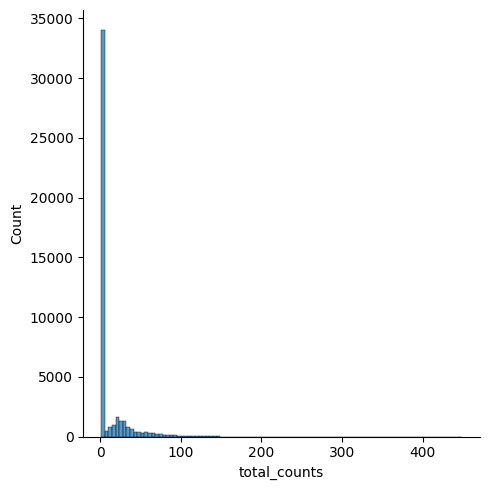

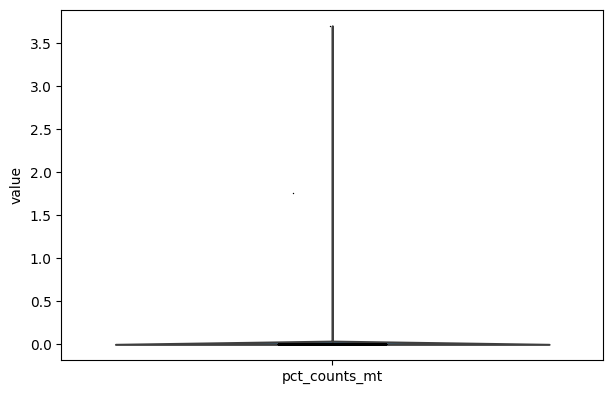

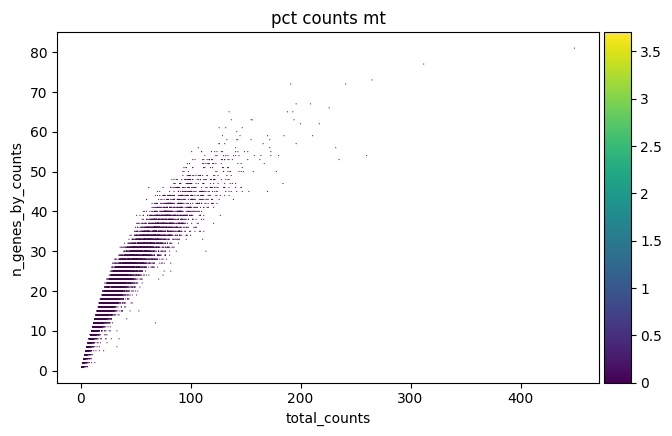

In [206]:
p1 = sns.displot(hca_adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(hca_adata, "pct_counts_mt")
p3 = sc.pl.scatter(hca_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [207]:
# have too much 0 for library size
hca_barcodes_to_keep, _ = sc.pp.filter_cells(hca_adata, min_counts=500, inplace = False)
# by default inplace = True, so adata is modified directly
hca_adata = hca_adata[hca_barcodes_to_keep, :]
hca_adata

View of AnnData object with n_obs × n_vars = 0 × 58347
    obs: 'cell_names', 'CellID', 'emptydrops_Limited', 'emptydrops_IsCell', 'n_reads', 'noise_reads', 'perfect_molecule_barcodes', 'reads_mapped_uniquely', 'reads_mapped_multiple', 'spliced_reads', 'antisense_reads', 'n_molecules', 'n_fragments', 'fragments_with_single_read_evidence', 'molecules_with_single_read_evidence', 'perfect_cell_barcodes', 'reads_mapped_too_many_loci', 'n_genes', 'genes_detected_multiple_observations', 'emptydrops_Total', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'reads_per_fragment', 'fragments_per_molecule', 'cell_barcode_fraction_bases_above_30_mean', 'cell_barcode_fraction_bases_above_30_variance', 'n_mitochondrial_genes', 'n_mitochondrial_molecules', 'pct_mitochondrial_mol

In [208]:
# mitochondrial genes: MT- for human data, mt- for mouse data
hca_adata.var["mt"] = hca_adata.var_names.str.startswith("MT-")
# check if have mouse mt genes
#todo: see alix function
count_true = (hca_adata.var_names.str.startswith("mt-")).sum()
print("mouse mt number", count_true)

# ribosomal genes
hca_adata.var["ribo"] = hca_adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
hca_adata.var["hb"] = hca_adata.var_names.str.contains(("^HB[^(P)]"))

mouse mt number 0


/var/folders/1h/vw_l9z3s1f131f4qs27kksgw0000gp/T/ipykernel_69970/1504952266.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  hca_adata.var["mt"] = hca_adata.var_names.str.startswith("MT-")


In [ ]:
p1 = sns.displot(hca_adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(hca_adata, "pct_counts_mt")
p3 = sc.pl.scatter(hca_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

##### 4.2. WLG pipeline

In [22]:
# mitochondrial genes: MT- for human data, mt- for mouse data
wlg_adata.var["mt"] = wlg_adata.var_names.str.startswith("MT-")
# check if have mouse mt genes
#todo: see alix function
count_true = (wlg_adata.var_names.str.startswith("mt-")).sum()
print("mouse mt number", count_true)

# ribosomal genes
wlg_adata.var["ribo"] = wlg_adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
wlg_adata.var["hb"] = wlg_adata.var_names.str.contains(("^HB[^(P)]"))

mouse mt number 0


In [23]:
# add qc metric to obs
sc.pp.calculate_qc_metrics(
    wlg_adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
wlg_adata

AnnData object with n_obs × n_vars = 1136912 × 58347
    obs: 'cell_names', 'CellID', 'emptydrops_Limited', 'emptydrops_IsCell', 'n_reads', 'noise_reads', 'perfect_molecule_barcodes', 'reads_mapped_exonic', 'reads_mapped_exonic_as', 'reads_mapped_intronic', 'reads_mapped_intronic_as', 'reads_mapped_uniquely', 'reads_mapped_multiple', 'duplicate_reads', 'spliced_reads', 'antisense_reads', 'n_molecules', 'n_fragments', 'fragments_with_single_read_evidence', 'molecules_with_single_read_evidence', 'perfect_cell_barcodes', 'reads_mapped_intergenic', 'reads_unmapped', 'reads_mapped_too_many_loci', 'n_genes', 'genes_detected_multiple_observations', 'emptydrops_Total', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'reads_per_molecule', 'reads_per_fragment', 'fragments

In [ ]:
p1 = sns.displot(wlg_adata.obs["total_counts"], bins=100, kde=False)
#sc.pl.violin(wlg_adata, 'total_counts')
p2 = sc.pl.violin(wlg_adata, "pct_counts_mt")
p3 = sc.pl.scatter(wlg_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [26]:
wlg_barcodes_to_keep, _ = sc.pp.filter_cells(wlg_adata, min_counts=500, inplace = False)
wlg_adata = wlg_adata[wlg_barcodes_to_keep, :]
wlg_adata

View of AnnData object with n_obs × n_vars = 12283 × 58347
    obs: 'cell_names', 'CellID', 'emptydrops_Limited', 'emptydrops_IsCell', 'n_reads', 'noise_reads', 'perfect_molecule_barcodes', 'reads_mapped_exonic', 'reads_mapped_exonic_as', 'reads_mapped_intronic', 'reads_mapped_intronic_as', 'reads_mapped_uniquely', 'reads_mapped_multiple', 'duplicate_reads', 'spliced_reads', 'antisense_reads', 'n_molecules', 'n_fragments', 'fragments_with_single_read_evidence', 'molecules_with_single_read_evidence', 'perfect_cell_barcodes', 'reads_mapped_intergenic', 'reads_unmapped', 'reads_mapped_too_many_loci', 'n_genes', 'genes_detected_multiple_observations', 'emptydrops_Total', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'reads_per_molecule', 'reads_per_fragment', 'fra

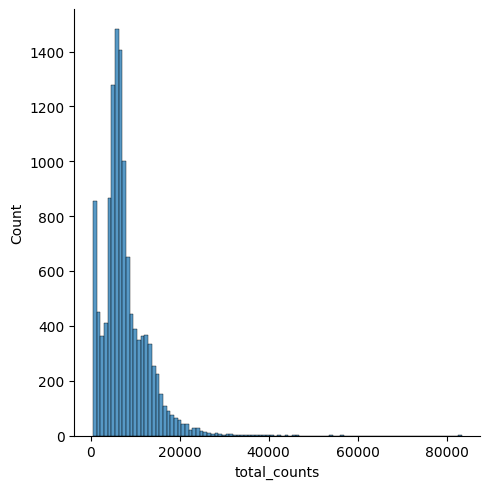

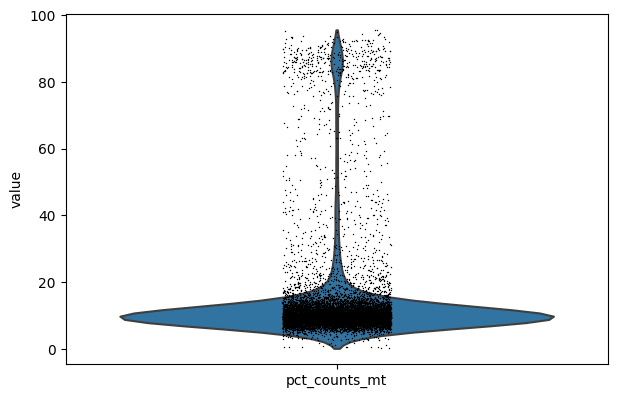

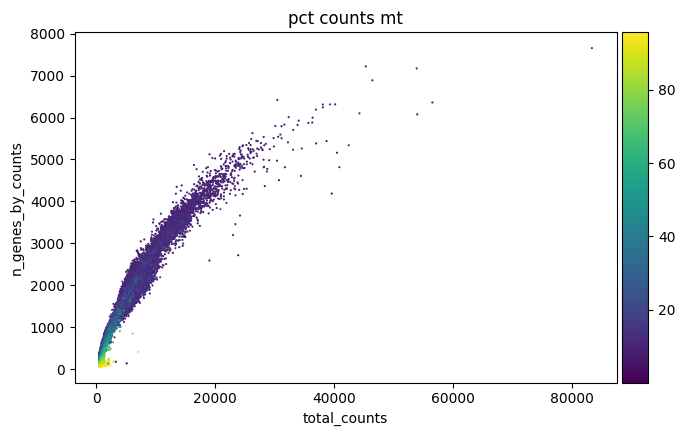

In [30]:
p1 = sns.displot(wlg_adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(wlg_adata, "pct_counts_mt")
p3 = sc.pl.scatter(wlg_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")